## Calibrating SoilNet for Conformal Horizon Description

In [1]:
import os
os.chdir('../../../')
!pwd

/mnt/KInsektDaten/teo


In [ ]:
import sys
sys.path.append('./BGR')
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score
from scipy.stats import linregress

from bgr.soil.data.horizon_tabular_data import HorizonDataProcessor
from bgr.soil.modelling.soilnet import SoilNet_LSTM
from bgr.soil.data.datasets import ImageTabularEnd2EndDataset
from bgr.soil.metrics import depth_iou
import bgr.soil.conformal as bgr_conform

In [3]:
dataprocessor = HorizonDataProcessor(label_embeddings_path='./BGR/label_embeddings/all_horizons_embeddings_thirds.pickle')
df = dataprocessor.load_processed_data()

train_df, val_df, calib_df, test_df = dataprocessor.multi_label_stratified_shuffle_split_calibrated(df, train_val_calib_test_frac=[0.6, 0.2, 0.1, 0.1], random_state=2025)

In [4]:
#soilnet_path = './BGR/models/end2ends/linear_decreasing_teacher/end2end_lstm_resnet_embed_2025-05-13_12-14-11/model.pt'
soilnet_path = './BGR/models/end2ends/linear_decreasing_teacher/end2end_lstm_resnet_2025-05-13_18-05-30/model.pt'
#soilnet_path = './BGR/models/end2ends/linear_decreasing_teacher/end2end_lstm_2025-05-13_12-13-14/model.pt'
output_shape = np.shape(dataprocessor.embeddings_dict['embedding']) # dimension of embeddings or number of classes
device = 'cuda:0'

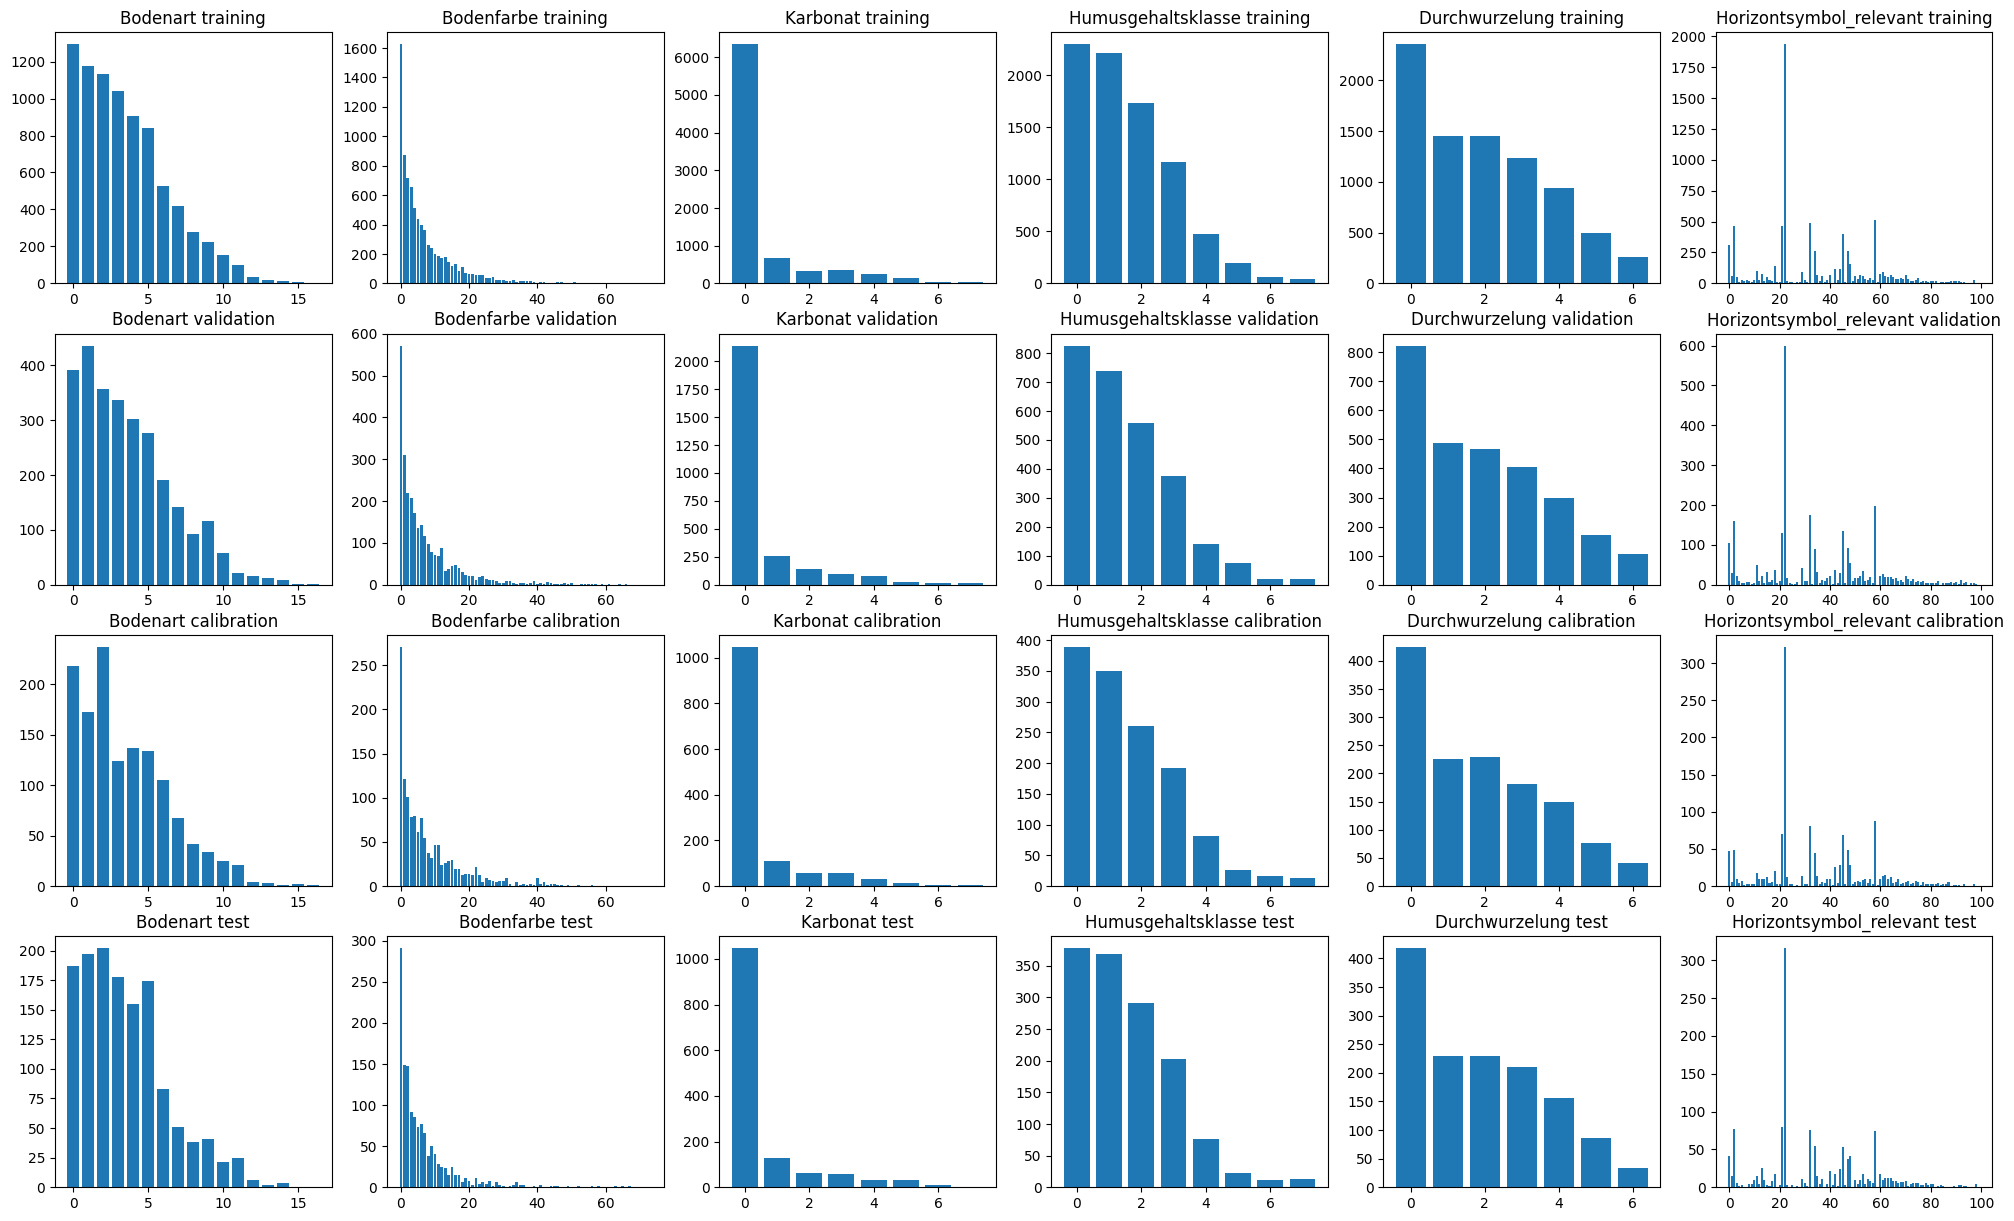

In [5]:
plt.figure(figsize=(25, 15))
for i, tab_feature in enumerate(list(dataprocessor.stratified_split_targets)):
    if tab_feature == 'Horizontsymbol_relevant':
        num_cls = output_shape[0]
    else:
        num_cls = dataprocessor.tabulars_output_dim_dict[tab_feature]

    counts_train = train_df[tab_feature].explode().value_counts().reindex(np.arange(num_cls), fill_value=0)
    counts_val   = val_df[tab_feature].explode().value_counts().reindex(np.arange(num_cls), fill_value=0)
    counts_calib = calib_df[tab_feature].explode().value_counts().reindex(np.arange(num_cls), fill_value=0)
    counts_test  = test_df[tab_feature].explode().value_counts().reindex(np.arange(num_cls), fill_value=0)

    plt.subplot(4, 6, i + 1)
    plt.bar(list(range(num_cls)), list(counts_train.values))
    plt.title(tab_feature + ' training')
    plt.subplot(4, 6, i + 7)
    plt.bar(list(range(num_cls)), list(counts_val.values))
    plt.title(tab_feature + ' validation')
    plt.subplot(4, 6, i + 13)
    plt.bar(list(range(num_cls)), list(counts_calib.values))
    plt.title(tab_feature + ' calibration')
    plt.subplot(4, 6, i + 19)
    plt.bar(list(range(num_cls)), list(counts_test.values))
    plt.title(tab_feature + ' test')
plt.show()

In [6]:
soilnet = SoilNet_LSTM(
    # Parameters for image encoder, geotemp encoder and depth predictor:
    geo_temp_input_dim        = len(dataprocessor.geotemp_img_infos) - 2, # without index and img path
    geo_temp_output_dim       = 256,
    image_encoder_output_dim  = 512,
    max_seq_len               = 8,
    stop_token                = 1.0,
    depth_rnn_hidden_dim      = 256,
    img_patch_size            = 512,
    segments_random_patches   = True if 'resnet' in soilnet_path else False, # True = use ResNet, False = use custom CNN
    num_patches_per_segment   = 8,
    segment_random_patch_size = 224,
    
    # Parameters for tabular predictors:
    tabular_output_dim_dict    = dataprocessor.tabulars_output_dim_dict,
    segment_encoder_output_dim = 512,
    tab_rnn_hidden_dim         = 1024,
    tab_num_lstm_layers        = 2,
    
    # Parameters for horizon predictor:
    segments_tabular_output_dim = 256,
    embedding_dim               = output_shape[1] if 'embed' in soilnet_path else output_shape[0],
    
    # Parameters for the model:
    teacher_forcing_stop_epoch  = -1, # no teacher forcing when doing only inference
    teacher_forcing_approach    = 'linear'
)

soilnet.load_state_dict(torch.load(soilnet_path, map_location=torch.device(device)))

/home/tchiaburu/anaconda3/envs/bgr/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


<All keys matched successfully>

In [7]:
subsets = []
for subset_df in [calib_df, test_df]:
    subset = ImageTabularEnd2EndDataset(
        dataframe=subset_df,
        normalize=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet statistics
            ]),
        label_column='Horizontsymbol_relevant',
        geotemp_columns=dataprocessor.geotemp_img_infos[:-1], # without img path
        tab_num_columns=['Steine'],
        tab_categ_columns={key : value 
                for key, value in dataprocessor.tabulars_output_dim_dict.items() 
                    if key in [
                            'Bodenart',
                            'Bodenfarbe',
                            'Karbonat',
                            'Humusgehaltsklasse',
                            'Durchwurzelung'
                        ]
            }
    )
    subsets.append(subset)

calib_dataset, test_dataset = subsets

In [8]:
batch_size = 8
calib_loader = calib_dataset.to_dataloader(batch_size = batch_size, shuffle = False, num_workers = 4)
test_loader  = test_dataset.to_dataloader(batch_size = batch_size,  shuffle = False, num_workers = 4)

In [ ]:
# Inference on the calibration set
segment_geotemp_features_calib, all_pred_depths_calib, \
    all_true_depths_calib, all_pred_logits_calib, all_true_hor_inds_calib = bgr_conform.soilnet_inference(calib_loader, soilnet, device)

In [ ]:
# Inference on the test set
segment_geotemp_features_test, all_pred_depths_test, \
    all_true_depths_test, all_pred_logits_test, all_true_hor_inds_test = bgr_conform.soilnet_inference(test_loader, soilnet, device)

### Calibrate Task 1

In [11]:
# Concatenate depths
all_pred_depths_calib = np.concatenate(all_pred_depths_calib, axis=0)
print(all_pred_depths_calib.shape)
all_pred_depths_test = np.concatenate(all_pred_depths_test, axis=0)
print(all_pred_depths_test.shape)

all_true_depths_calib = np.concatenate(all_true_depths_calib, axis=0)
print(all_true_depths_calib.shape)
all_true_depths_test = np.concatenate(all_true_depths_test, axis=0)
print(all_true_depths_test.shape)

(335, 8)
(335, 8)
(335, 8)
(335, 8)


In [12]:
# Unbatch seg. geotemp. features
segment_geotemp_list_calib = [item for sublist in segment_geotemp_features_calib for item in sublist]
print(len(segment_geotemp_list_calib))
segment_geotemp_list_test = [item for sublist in segment_geotemp_features_test for item in sublist]
print(len(segment_geotemp_list_test))

335
335


In [ ]:
# Trim true and predicted depths from trailing stop tokens and stack them
trimmed_true_depths_stacked_calib, \
    trimmed_pred_depths_stacked_calib, \
        segment_geotemp_concat_calib = bgr_conform.trim_concat(all_true_depths_calib, all_pred_depths_calib, segment_geotemp_list_calib)
trimmed_true_depths_stacked_test, \
    trimmed_pred_depths_stacked_test, \
        segment_geotemp_concat_test   = bgr_conform.trim_concat(all_true_depths_test, all_pred_depths_test, segment_geotemp_list_test)
print(len(trimmed_true_depths_stacked_calib))
print(len(trimmed_pred_depths_stacked_calib))
print(len(segment_geotemp_concat_calib))
print(len(trimmed_true_depths_stacked_test))
print(len(trimmed_pred_depths_stacked_test))
print(len(segment_geotemp_concat_test))

1327
1327
1327
1364
1364
1364


In [14]:
# Compute conformity scores as s_x = |true_depth - pred_depth_x|
conf_scores_depths_calib = torch.abs(trimmed_true_depths_stacked_calib - trimmed_pred_depths_stacked_calib).to(torch.float32)
print(conf_scores_depths_calib.shape)
conf_scores_depths_test = torch.abs(trimmed_true_depths_stacked_test - trimmed_pred_depths_stacked_test).to(torch.float32)
print(conf_scores_depths_test.shape)

torch.Size([1327])
torch.Size([1364])


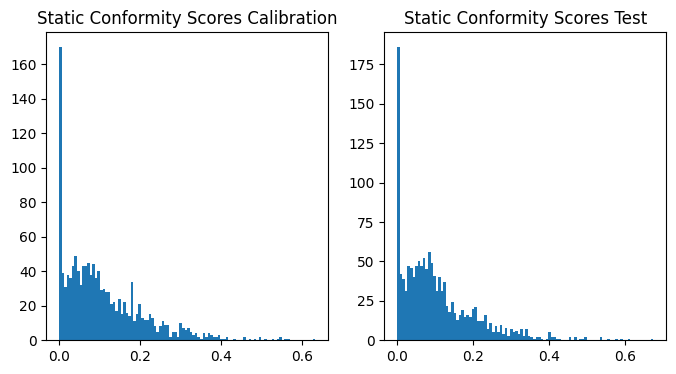

In [15]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.hist(conf_scores_depths_calib.numpy(), bins=100)
plt.title('Static Conformity Scores Calibration')
plt.subplot(122)
plt.hist(conf_scores_depths_test.numpy(), bins=100)
plt.title('Static Conformity Scores Test');

In [16]:
resid_dataset_calib = TensorDataset(segment_geotemp_concat_calib, conf_scores_depths_calib)
resid_loader_calib  = DataLoader(resid_dataset_calib, batch_size=batch_size, shuffle=False)
# Note: don't shuffle, so that the predicted residuals match the conformity scores

resid_dataset_test = TensorDataset(segment_geotemp_concat_test, conf_scores_depths_test)
resid_loader_test  = DataLoader(resid_dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
# Initialize residual model
residual_model = bgr_conform.ResidualPredictor(input_dim=segment_geotemp_concat_calib.shape[1])
# Load model if pretrained
residual_model.load_state_dict(torch.load('./BGR/models/conformal/residual_resnet_mlp_softplus.pt'))
#residual_model.load_state_dict(torch.load('./BGR/models/conformal/residual_cnn_mlp_softplus.pt'))

<All keys matched successfully>

Epoch 0: Train Loss = 0.1048, Validation Loss = 0.0366
Epoch 1: Train Loss = 0.0285, Validation Loss = 0.0276
Epoch 2: Train Loss = 0.0240, Validation Loss = 0.0253
Epoch 3: Train Loss = 0.0225, Validation Loss = 0.0244
Epoch 4: Train Loss = 0.0216, Validation Loss = 0.0239
Epoch 5: Train Loss = 0.0210, Validation Loss = 0.0235
Epoch 6: Train Loss = 0.0205, Validation Loss = 0.0232
Epoch 7: Train Loss = 0.0201, Validation Loss = 0.0229
Epoch 8: Train Loss = 0.0197, Validation Loss = 0.0227
Epoch 9: Train Loss = 0.0194, Validation Loss = 0.0225


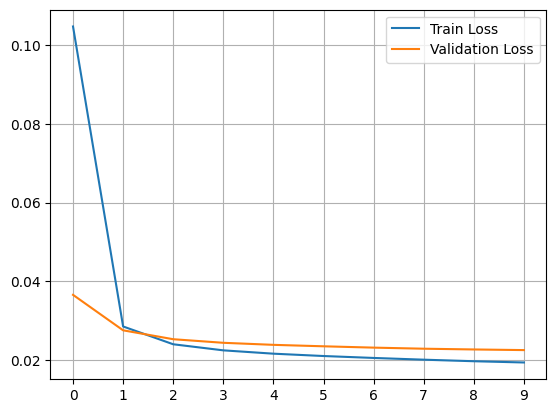

In [18]:
optimizer = torch.optim.Adam(residual_model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
train_loss_hist, val_loss_hist = [], []
num_epochs = 10

# Training loop (on the calibration set)
for epoch in range(num_epochs):
    residual_model.train()
    total_train_loss = 0.0
    for x_batch, r_batch in resid_loader_calib:
        optimizer.zero_grad()
        r_hat = residual_model(x_batch)
        loss = criterion(r_hat, r_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(resid_loader_calib)
    train_loss_hist.append(avg_train_loss)
    
    # Evaluate on test set
    residual_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x_batch, r_batch in resid_loader_test:
            r_hat = residual_model(x_batch)
            loss = criterion(r_hat, r_batch)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(resid_loader_test)
    val_loss_hist.append(avg_val_loss)
    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Validation Loss = {avg_val_loss:.4f}")   
    
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.xticks(np.arange(num_epochs))
plt.grid()
plt.legend();

# Save residual model weights
torch.save(residual_model.state_dict(), './BGR/models/conformal/residual_cnn_mlp_softplus.pt')

In [18]:
# Predict the residuals on the calibration set to rescale the conformity scores
pred_residuals_calib = residual_model(segment_geotemp_concat_calib)
print(len(pred_residuals_calib))

# Also on the test set for inference later
pred_residuals_test = residual_model(segment_geotemp_concat_test)
print(len(pred_residuals_test))

1327
1364


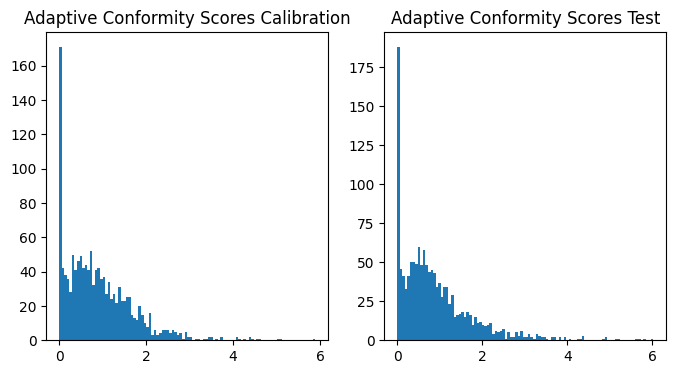

In [19]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.hist((conf_scores_depths_calib / pred_residuals_calib).detach().numpy(), bins=100)
plt.title('Adaptive Conformity Scores Calibration')
plt.subplot(122)
plt.hist((conf_scores_depths_test / pred_residuals_test).detach().numpy(), bins=100)
#plt.xlim([0, 5])
plt.title('Adaptive Conformity Scores Test');

In [20]:
# Compute quantile on calibration set
quant = 0.9 * (len(conf_scores_depths_calib)+1) / len(conf_scores_depths_calib) # apply finite sample correction
qhat_depth = torch.quantile(conf_scores_depths_calib / pred_residuals_calib, quant).detach().numpy()
qhat_depth
# Note: 2*qhat_depth*pred_residual_x = width of the confidence interval centered at the predicted depth 

array(1.9167895, dtype=float32)

In [77]:
# For comparison: is the quantile on the test set also roughly around the quantile on the calib. set?
qhat_depth_test = torch.quantile(conf_scores_depths_test / pred_residuals_test, quant).detach().numpy()
qhat_depth_test

array(2.0004637, dtype=float32)

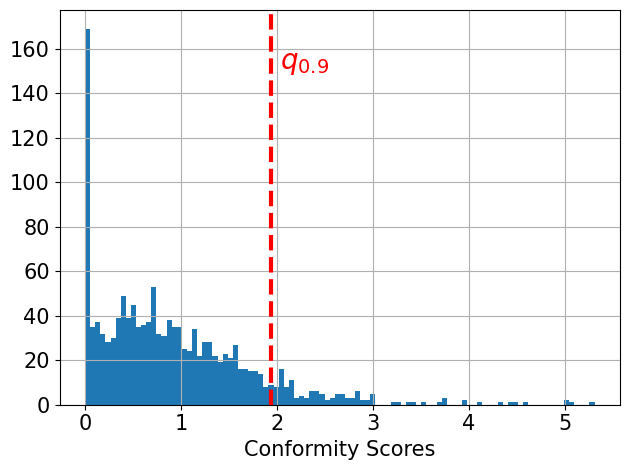

In [79]:
fsize = 15
plt.hist((conf_scores_depths_calib / pred_residuals_calib).detach().numpy(), bins=100)
plt.axvline(x=qhat_depth, color='red', linestyle='--', linewidth=3)
plt.xlabel('Conformity Scores', fontsize=fsize)
plt.xticks(fontsize=fsize); plt.yticks(fontsize=fsize)
plt.text(qhat_depth + 0.1, plt.ylim()[1]*0.85, r'$q_{0.9}$', color='red', fontsize=fsize+5)
plt.grid()
plt.tight_layout()
plt.savefig('./BGR/figures/conformal/task1_conf_scores_calib_resnet.pdf')

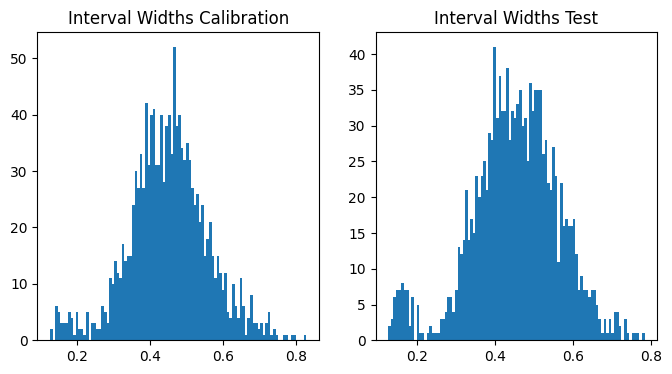

In [21]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.hist(2 * qhat_depth * pred_residuals_calib.detach().numpy(), bins=100)
plt.title('Interval Widths Calibration')
plt.subplot(122)
plt.hist(2 * qhat_depth * pred_residuals_test.detach().numpy(), bins=100)
plt.title('Interval Widths Test');

#### Visualize one example

In [22]:
ex_ind = 8 #1, 5

# Get index of the stop token of the chosen example
stop_token_occurrences = (trimmed_true_depths_stacked_test == 1.0).nonzero(as_tuple=True)[0]
top_ind, bottom_ind = stop_token_occurrences[ex_ind-1]+1 if ex_ind > 0 else 0, stop_token_occurrences[ex_ind]+1
print(top_ind, bottom_ind)

# Retrieve image from batched dataloader
ex_num_batches = ex_ind // batch_size
ex_samples_last_batch = ex_ind % batch_size
for i, batch in enumerate(test_loader):
    if i == ex_num_batches:
        padded_images, image_masks, _, _, _, _ = batch
        padded_image, image_mask = padded_images[ex_samples_last_batch].to(device), image_masks[ex_samples_last_batch].to(device)
        break

# Unpad image
_, row_inds, col_inds = np.where(image_mask.cpu().numpy() == True)
row_ind, col_ind = max(row_inds), max(col_inds)
orig_img = padded_image[:, :row_ind, :col_ind]
print(orig_img.shape)

img_height = orig_img.shape[1]
eps = 0.001
mean = torch.tensor([0.485, 0.456, 0.406], device=device) # denormalize image
std  = torch.tensor([0.229, 0.224, 0.225], device=device) 
orig_img = orig_img * std[:, None, None] + mean[:, None, None]
orig_img = orig_img.permute(1, 2, 0).cpu().numpy()

tensor(33) tensor(38)


torch.Size([3, 2641, 1536])


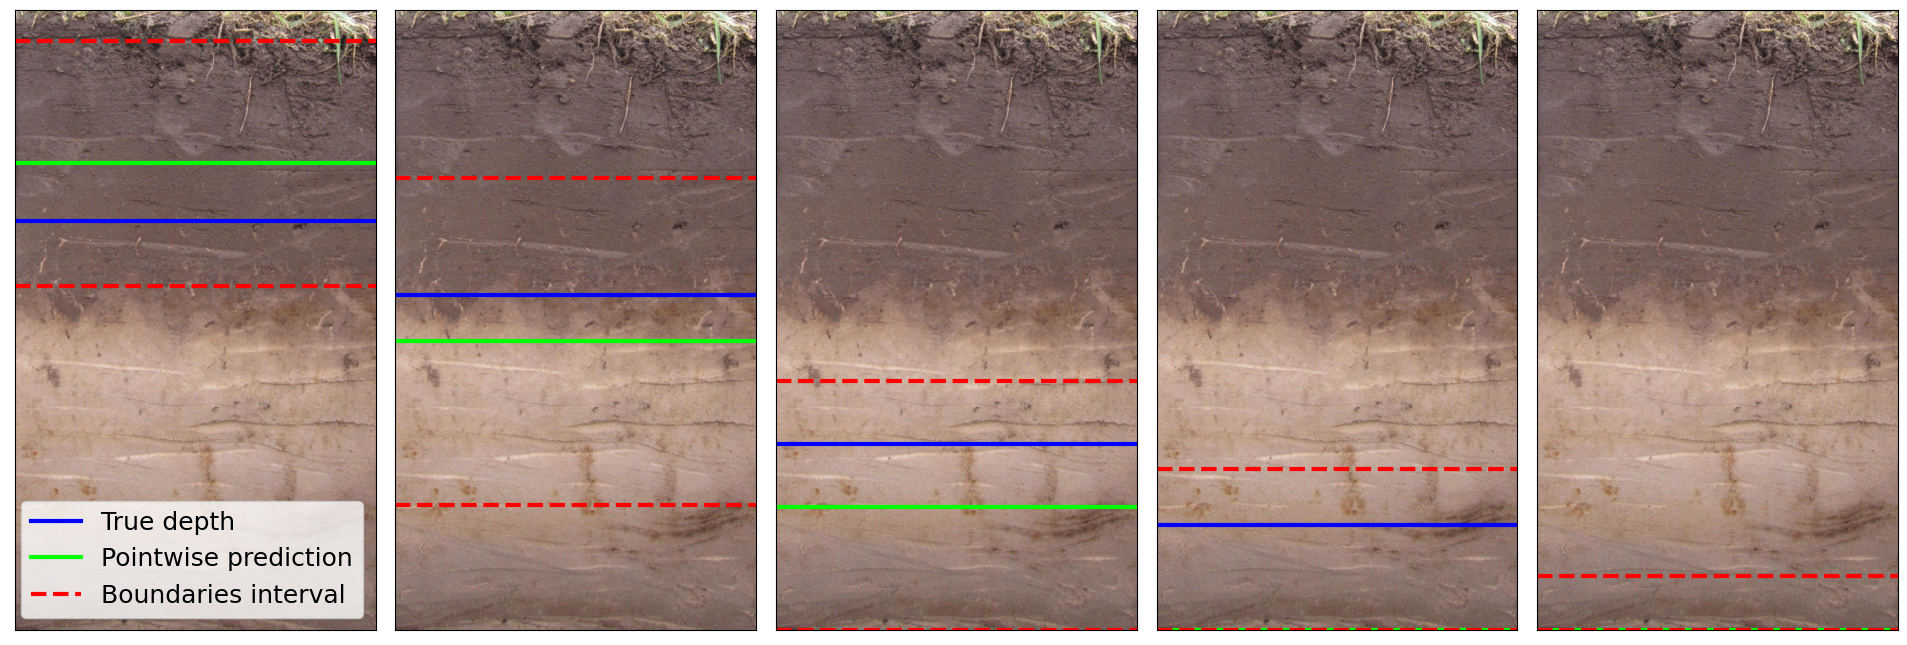

In [24]:
# Plot prediction intervals for all pointwise predicted markers
fsize = 18
plt.figure(figsize=(20, 14))
for i, ind in enumerate(range(top_ind, bottom_ind)):
    plt.subplot(1, (bottom_ind-top_ind).tolist(), i+1)
    plt.imshow(orig_img)
    
    pred_depth = np.min((trimmed_pred_depths_stacked_test[ind], 1.0-eps)) # subtract an epsilon here to avoid plot artifacts at the final prediction
    true_depth = np.min((trimmed_true_depths_stacked_test[ind], 1.0-eps))
    
    # Get the confidence interval width
    lower = np.max((eps, pred_depth - qhat_depth * pred_residuals_test[ind].detach().numpy()))
    upper = np.min((pred_depth + qhat_depth * pred_residuals_test[ind].detach().numpy(), 1.0-eps))

    # Convert normalized depths to pixel coordinates
    plt.axhline(y=true_depth * img_height, color='blue', linestyle='-', linewidth=3)
    plt.axhline(y=pred_depth * img_height, color='lime', linestyle='-', linewidth=3)
    plt.axhline(y=lower * img_height, color='red', linestyle='--', linewidth=3)
    plt.axhline(y=upper * img_height, color='red', linestyle='--', linewidth=3)
    if i == 0: plt.legend(['True depth', 'Pointwise prediction', 'Boundaries interval'], loc='lower right', fontsize=fsize)
    plt.xticks([]);plt.yticks([])
plt.tight_layout()
plt.savefig('./BGR/figures/conformal/ex_depth_intervals_resnet.pdf')
plt.show()

### Calibrate Task 3

In [11]:
# Concatenate pred. logits and true horizon indexes
all_pred_logits_calib = torch.from_numpy(np.concatenate(all_pred_logits_calib, axis=0))
print(all_pred_logits_calib.shape)
all_pred_logits_test = torch.from_numpy(np.concatenate(all_pred_logits_test, axis=0))
print(all_pred_logits_test.shape)

all_true_hor_inds_calib = torch.from_numpy(np.concatenate(all_true_hor_inds_calib, axis=0))
print(all_true_hor_inds_calib.shape)
all_true_hor_inds_test = torch.from_numpy(np.concatenate(all_true_hor_inds_test, axis=0))
print(all_true_hor_inds_test.shape)

torch.Size([1327, 100])
torch.Size([1364, 100])
torch.Size([1327])
torch.Size([1364])


In [12]:
# Apply softmax on pred. logits (in Pytorch, the CE loss applies softmax itself on the output layer)
all_pred_probs_calib = F.softmax(all_pred_logits_calib, dim=1)
print(all_pred_probs_calib.shape)
all_pred_probs_test = F.softmax(all_pred_logits_test, dim=1)
print(all_pred_probs_test.shape)

torch.Size([1327, 100])
torch.Size([1364, 100])


In [13]:
# Get probabilities of the true class
prob_true_class_calib = all_pred_probs_calib[torch.arange(len(all_true_hor_inds_calib)), all_true_hor_inds_calib]
print(prob_true_class_calib.shape)
prob_true_class_test = all_pred_probs_test[torch.arange(len(all_true_hor_inds_test)), all_true_hor_inds_test]
print(prob_true_class_test.shape)

torch.Size([1327])
torch.Size([1364])


In [14]:
# Compute quantile on conformity scores: 1 - softmax(f(x))_true 
quant = 0.9 * (len(prob_true_class_calib)+1)/len(prob_true_class_calib) # apply finite sample correction (n+1)/n
qhat_horizon = torch.quantile(1 - prob_true_class_calib, quant)
qhat_horizon

tensor(0.9940)

In [29]:
# For comparison: quantile on the test set 
qhat_horizon_test = torch.quantile(1 - prob_true_class_test, quant)
qhat_horizon_test

tensor(0.9941)

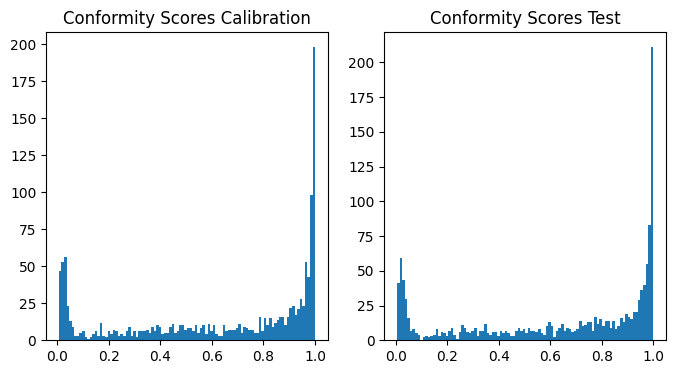

In [30]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.hist((1 - prob_true_class_calib).numpy(), bins=100)
plt.title('Conformity Scores Calibration')
plt.subplot(122)
plt.hist((1 - prob_true_class_test).numpy(), bins=100)
plt.title('Conformity Scores Test');

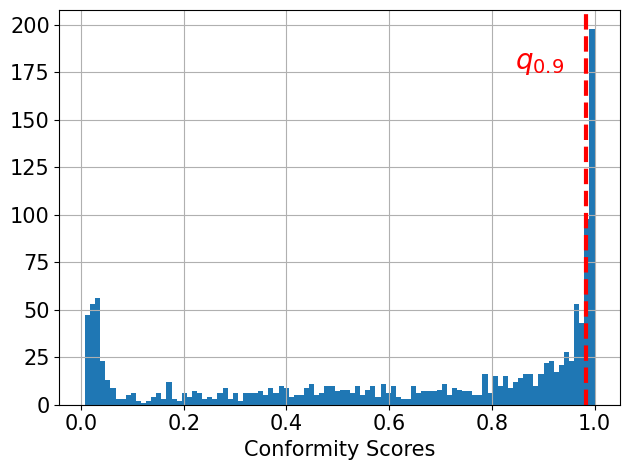

In [63]:
fsize = 15
plt.hist((1 - prob_true_class_calib).numpy(), bins=100)
plt.axvline(x=qhat_horizon-0.01, color='red', linestyle='--', linewidth=3)
plt.xlabel('Conformity Scores', fontsize=fsize)
plt.xticks(fontsize=fsize); plt.yticks(fontsize=fsize)
plt.text(qhat_horizon - 0.15, plt.ylim()[1]*0.85, r'$q_{0.9}$', color='red', fontsize=fsize+5)
plt.grid()
plt.tight_layout()
plt.savefig('./BGR/figures/conformal/task3_conf_scores_calib_resnet.pdf')

In [15]:
# Predict label sets
calib_prediction_sets = (1 - all_pred_probs_calib <= qhat_horizon) 
test_prediction_sets  = (1 - all_pred_probs_test <= qhat_horizon) 
print(test_prediction_sets.shape)
test_prediction_sets

torch.Size([1364, 100])


tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [ True, False,  True,  ..., False, False, False]])

In [16]:
# Get the mapping from index to label
horizon_labels = dataprocessor.embeddings_dict['ind2label']

# For each row in prediction_sets, get the list of labels where the prediction set is True
predicted_label_lists_calib = [
    [horizon_labels[i] for i, is_in_set in enumerate(row) if is_in_set]
    for row in calib_prediction_sets.cpu().numpy()
]
predicted_label_lists_test = [
    [horizon_labels[i] for i, is_in_set in enumerate(row) if is_in_set]
    for row in test_prediction_sets.cpu().numpy()
]

In [69]:
for i, pred_sets in enumerate(predicted_label_lists_test):
    if i == 20: break
    print(pred_sets)

['Ap']
['Ael', 'Bhv', 'Ap', 'Bv', 'M.', 'Sw', 'Al', 'Sw-Bv', 'Al-Bv']
['ilC', 'Ael', 'Sd', 'Cv', 'Bhv', 'Bvt', 'Go', 'Ap', 'Bv', 'lC', 'M.', 'Sw', 'Bt', 'Btv', 'Al', 'Sw-Bv', 'Bv-ilC', 'Bv-Sw', 'Bt-Sd', 'Bv-Cv', 'Al-Bv', 'Sd-Bt', 'Ael-Bt']
['ilC', 'Sd', 'Cv', 'Go', 'Bv', 'elC', 'lC', 'Sw', 'Bt', 'Btv', 'Sw-Bv', 'Bv-ilC', 'Bv-Sw', 'Bt-Sd', 'Bv-Cv', 'Sd-ilC', 'Sd-Bt', 'Ael-Bt', 'Go-ilC', 'Sd-Bv']
['ilC', 'Sd', 'Cv', 'Go', 'Bv', 'elC', 'lC', 'Sw', 'Bt', 'Btv', 'Bv-ilC', 'Bt-Sd', 'Bv-Cv', 'Sd-ilC', 'Sd-Bt', 'Go-ilC', 'Sd-Bv']
['ilC', 'Sd', 'C.', 'Cv', 'Gro', 'Go', 'Bv', 'elC', 'lC', 'Cj', 'Gr', 'Gor', 'Sw', 'Bt', 'Btv', 'Bv-ilC', 'Bt-Sd', 'Bv-Cv', 'Sd-ilC', 'Sd-Bt', 'Go-ilC', 'Sd-Bv']
['Ap', 'Ah']
['ilC', 'Ael', 'E.', 'Bhv', 'Bvt', 'Ap', 'Acp', 'Bv', 'M.', 'Bt', 'Btv', 'Al', 'Sw-Bv', 'Bv-ilC', 'Al-Bv', 'Sw-Al', 'Sw-Ap', 'Bv-Ael']
['ilC', 'Ael', 'Sd', 'Cv', 'Bhv', 'Bvt', 'Bv', 'lC', 'Sw', 'Bt', 'Btv', 'Al', 'Sw-Bv', 'Bv-ilC', 'Bv-Sw', 'Bt-Sd', 'Bv-Cv', 'Al-Sw', 'Al-Bv', 'Sw-Al', 'Sd-Bt', 'A

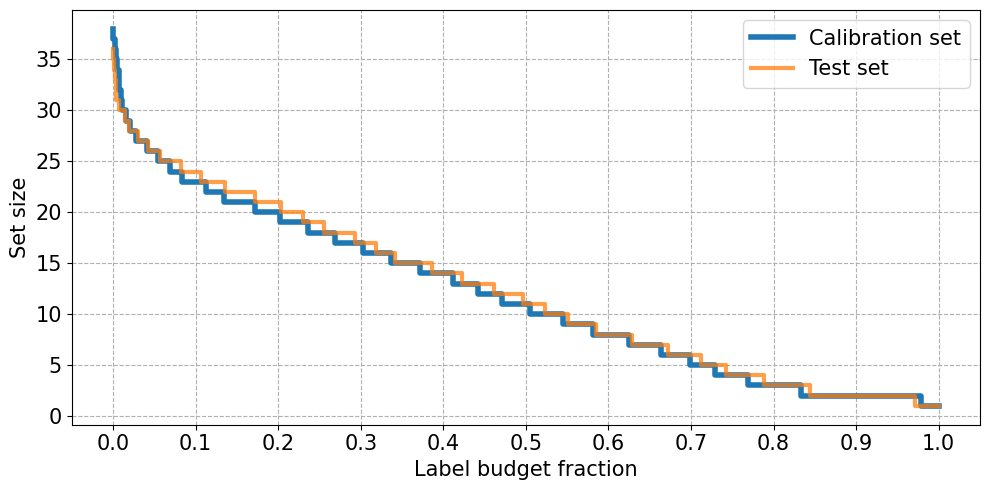

In [29]:
normalized_cumulative_counts_calib, bin_edges_calib = cumulate_set_sizes(predicted_label_lists_calib)
normalized_cumulative_counts_test,  bin_edges_test  = cumulate_set_sizes(predicted_label_lists_test)

fsize = 15
plt.figure(figsize=(10, 5))
plt.step(1 - normalized_cumulative_counts_calib, bin_edges_calib[1:], where='post', linewidth=4)
plt.step(1 - normalized_cumulative_counts_test,  bin_edges_test[1:],  where='post', linewidth=3, alpha=0.75)
plt.ylabel('Set size', fontsize=fsize)
plt.xlabel('Label budget fraction', fontsize=fsize)
plt.grid(True, linestyle='--')
plt.xticks(np.linspace(0.0, 1.0, 11), fontsize=fsize); plt.yticks(fontsize=fsize)
plt.legend(['Calibration set', 'Test set'], fontsize=fsize)
plt.tight_layout()
plt.savefig('./BGR/figures/conformal/cumulative_calib_test.pdf')

#### Examine calibration before and after conformalizing

Compare fractions of true positives (nonconformal) against coverage rates (conformal) for the same confidence levels.

In [ ]:
# Calibration curve before conformalizing
n_bins = 10
mae_soft_test, ece_soft_test, accs_test, confs_test = bgr_conform.compute_calibration_curve_nonconformal(all_pred_probs_test, all_true_hor_inds_test, n_bins)
print('Nonconformal model')
print(f'Mean Absolute Error: {mae_soft_test}')
print(f'Expected Calibration Error: {ece_soft_test}')

Mean Average Error: 0.12093094329619328
Expected Calibration Error: 0.10737996046428631


In [ ]:
# Calibrate model for multiple confidence levels and check if the coverage rate (is the true label in the predicted set?) agrees with the guarantee
# Use the same xticks as the confidences in the nonconformal plot
target_coverages = confs_test
test_prediction_sets = {}

for tc in target_coverages:
    # Compute quantile on conformity scores: 1 - softmax(f(x))_true (always on calibration set)
    quant = tc * (len(prob_true_class_calib)+1)/len(prob_true_class_calib) # apply finite sample correction (n+1)/n
    qhat_hor = torch.quantile(1 - prob_true_class_calib, quant)
    
    # Create boolean tensors marking which labels make it into the prediction sets
    test_prediction_sets[tc] = (1 - all_pred_probs_test <= qhat_hor) 
    
empirical_coverages_test = bgr_conform.evaluate_coverage(test_prediction_sets, all_true_hor_inds_test, target_coverages)

In [ ]:
mae_conf_test = 0.0
for conf, cover in zip(confs_test, empirical_coverages_test):
    mae_conf_test += np.abs(conf - cover) / n_bins
print('Conformal Model')
print(f'Mean Absolute Error: {mae_conf_test}')

0.007934353282112517

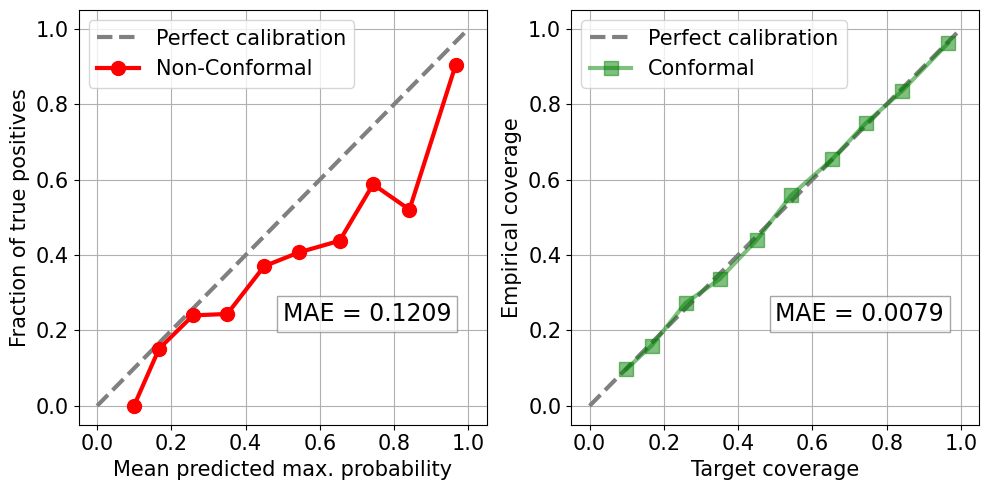

In [101]:
fsize = 15
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=3)
plt.plot(confs_test, accs_test, marker='o', linewidth=3, markersize=10, color='red')
plt.text(0.5, 0.25, f'MAE = {mae_soft_test:.4f}', transform=plt.gca().transAxes, fontsize=fsize+2, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.xlabel('Mean predicted max. probability', fontsize=fsize); plt.ylabel('Fraction of true positives', fontsize=fsize)
plt.xticks(fontsize=fsize); plt.yticks(fontsize=fsize)
plt.legend(['Perfect calibration', 'Non-Conformal'], fontsize=fsize)
plt.grid(True)

plt.subplot(122)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=3)
plt.plot(confs_test, empirical_coverages_test, marker='s', linewidth=3, markersize=10, color='green', alpha=0.5)
plt.text(0.5, 0.25, f'MAE = {mae_conf_test:.4f}', transform=plt.gca().transAxes, fontsize=fsize+2, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.xlabel('Target coverage', fontsize=fsize); plt.ylabel('Empirical coverage', fontsize=fsize)
plt.xticks(fontsize=fsize); plt.yticks(fontsize=fsize)
plt.legend(['Perfect calibration', 'Conformal'], fontsize=fsize)
plt.grid(True)

plt.tight_layout()
plt.savefig('./BGR/figures/conformal/calibration_conf_vs_nonconf.pdf')
plt.show()

### Oracle Simulations

In [ ]:
label_budgets = [100, 200, 300, 400, 500] # how many oracle questions can we ask per task
uncert_thresholds = [0.9, 0.8, 0.7, 0.6, 0.5]
max_seq_len = all_true_depths_test.shape[1]

#### Conformal vs Non-Conformal Depth Predictor

In [43]:
# Compute IoU on test set for pointwise depth predictor
iou_uncorr = depth_iou(torch.tensor(all_pred_depths_test), torch.tensor(all_true_depths_test))
print(iou_uncorr)

tensor(0.4929)


In [36]:
# Count horizons in the true depths (needed for unstacking the predictions later)
counts_until_stop = []
count = 0
for val in trimmed_true_depths_stacked_test:
    if val == 1.0:
        counts_until_stop.append(count + 1)  # include the stop token itself
        count = 0
    else:
        count += 1

Correct predictions at random

In [ ]:
num_simulations = 100
rand_iou = {}
for lb in label_budgets:
    avg_depth_iou_rand = 0.0
    for i in range(num_simulations):
        # Select label_budget depth predictions to replace with the ground truth
        random_indices = np.random.choice(len(trimmed_pred_depths_stacked_test), lb, replace=False)

        # Replace these random predictions with the oracle's answers (the ground truth depths)
        pred_depths_test_oracle_rand = trimmed_pred_depths_stacked_test.clone().detach()
        pred_depths_test_oracle_rand[random_indices] = trimmed_true_depths_stacked_test[random_indices]
        
        # Split and pad corrected predictions
        padded_pred_depths_test_oracle_resid = bgr_conform.split_pad(counts_until_stop, pred_depths_test_oracle_rand, max_seq_len)
            
        # Compute IoU on corrected depths
        avg_depth_iou_rand += depth_iou(torch.tensor(padded_pred_depths_test_oracle_resid), torch.tensor(all_true_depths_test))
    
    avg_depth_iou_rand = avg_depth_iou_rand/num_simulations    
    rand_iou[lb] = avg_depth_iou_rand
    print(f'Average Depth IoU after random corrections for lb = {lb}: {avg_depth_iou_rand}')

Average Depth IoU after random corrections for lb = 100: 0.5232547521591187
Average Depth IoU after random corrections for lb = 200: 0.5540103316307068
Average Depth IoU after random corrections for lb = 300: 0.5871647000312805
Average Depth IoU after random corrections for lb = 400: 0.6195991039276123
Average Depth IoU after random corrections for lb = 500: 0.654746949672699


Correct predictions according to MCD std. deviations

In [ ]:
# 2 inferences take about 1 minute
all_pred_mean_depths, all_pred_std_depths = bgr_conform.soilnet_inference_mcd_depths(test_loader, soilnet, device, num_inferences=50)

# Store MCD predictions
with open('./BGR/models/conformal/mcd_test_resnet_means.pkl', 'wb') as f:
    pickle.dump(all_pred_mean_depths, f)
with open('./BGR/models/conformal/mcd_test_resnet_stds.pkl', 'wb') as f:
    pickle.dump(all_pred_std_depths, f)

In [ ]:
# Load MCD predictions
with open('./BGR/models/conformal/mcd_test_resnet_means.pkl', 'rb') as f:
    all_pred_mean_depths = pickle.load(f)
with open('./BGR/models/conformal/mcd_test_resnet_stds.pkl', 'rb') as f:
    all_pred_std_depths = pickle.load(f)

In [39]:
# Concatenate MCD depths means and stds
all_pred_mean_depths = np.concatenate(all_pred_mean_depths, axis=0)
print(all_pred_mean_depths.shape)
all_pred_std_depths = np.concatenate(all_pred_std_depths, axis=0)
print(all_pred_std_depths.shape)

(335, 8)
(335, 8)


In [ ]:
# Trim and concatenate the std. devs
_, trimmed_pred_std_depths, _ = bgr_conform.trim_concat(all_true_depths_test, all_pred_std_depths, segment_geotemp_list_test)
trimmed_pred_std_depths.shape

torch.Size([1364])

In [ ]:
mcd_iou = {}
for lb in label_budgets:
    # Select top-k (for k = label_budget) most uncertain depth predictions based on the std. devs of the MCD predictions
    _, topk_indices = torch.topk(trimmed_pred_std_depths, lb)
    topk_indices = topk_indices.cpu().numpy()

    # Replace these uncertain predictions with the oracle's answers (the ground truth depths)
    pred_depths_test_oracle_mcd = trimmed_pred_depths_stacked_test.clone().detach()
    pred_depths_test_oracle_mcd[topk_indices] = trimmed_true_depths_stacked_test[topk_indices]

    # Split and pad corrected predictions
    padded_pred_depths_test_oracle_mcd = bgr_conform.split_pad(counts_until_stop, pred_depths_test_oracle_mcd, max_seq_len)

    # Compute IoU on corrected depths
    iou = depth_iou(torch.tensor(padded_pred_depths_test_oracle_mcd), torch.tensor(all_true_depths_test))
    mcd_iou[lb] = iou
    print(f'Depth IoU after conformal corrections for lb = {lb}: {iou}')

Depth IoU after conformal corrections for lb = 100: 0.5191237330436707
Depth IoU after conformal corrections for lb = 200: 0.5516625046730042
Depth IoU after conformal corrections for lb = 300: 0.5855562686920166
Depth IoU after conformal corrections for lb = 400: 0.6186593174934387
Depth IoU after conformal corrections for lb = 500: 0.6552472710609436


Correct predictions according to widths of confidence intervals

In [ ]:
conf_iou = {}
for lb in label_budgets:
    # Select top-k (for k = label_budget) most uncertain depth predictions based on the widths of the calibrated intervals
    # 2*qhat_depth*pred_residual_x = width of confidence interval
    _, topk_indices = torch.topk(2*qhat_depth*pred_residuals_test, lb)
    topk_indices = topk_indices.cpu().numpy()

    # Replace these uncertain predictions with the oracle's answers (the ground truth depths)
    pred_depths_test_oracle_conf = trimmed_pred_depths_stacked_test.clone().detach()
    pred_depths_test_oracle_conf[topk_indices] = trimmed_true_depths_stacked_test[topk_indices]

    # Split and pad corrected predictions
    padded_pred_depths_test_oracle_conf = bgr_conform.split_pad(counts_until_stop, pred_depths_test_oracle_conf, max_seq_len)

    # Compute IoU on corrected depths
    iou = depth_iou(torch.tensor(padded_pred_depths_test_oracle_conf), torch.tensor(all_true_depths_test))
    conf_iou[lb] = iou
    print(f'Depth IoU after conformal corrections for lb = {lb}: {iou}')

Depth IoU after conformal corrections for lb = 100: 0.5294739603996277
Depth IoU after conformal corrections for lb = 200: 0.5620089173316956
Depth IoU after conformal corrections for lb = 300: 0.5981411337852478
Depth IoU after conformal corrections for lb = 400: 0.6338120102882385
Depth IoU after conformal corrections for lb = 500: 0.6675502061843872


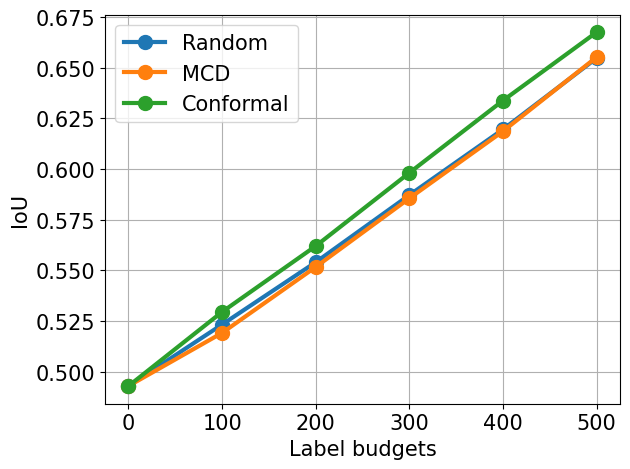

In [46]:
fsize = 15
extended_label_budgets = [0] + label_budgets
plt.plot(extended_label_budgets, [iou_uncorr] + list(rand_iou.values()), marker='o', linewidth=3, markersize=10)
plt.plot(extended_label_budgets, [iou_uncorr] + list(mcd_iou.values()), marker='o', linewidth=3, markersize=10)
plt.plot(extended_label_budgets, [iou_uncorr] + list(conf_iou.values()), marker='o', linewidth=3, markersize=10)
plt.xticks(extended_label_budgets, labels=[str(lb) for lb in extended_label_budgets], fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xlabel('Label budgets', fontsize=fsize); plt.ylabel('IoU', fontsize=fsize)
plt.legend(['Random', 'MCD', 'Conformal'], fontsize=fsize)
plt.grid()
plt.tight_layout()
plt.savefig('./BGR/figures/conformal/task1_lb_resnet.pdf')

#### Conformal vs Non-Conformal Horizon Predictor

In [56]:
# Get accuracy on test set without any corrections
pred_indices_test = torch.argmax(all_pred_probs_test, dim=1)
accuracy = (pred_indices_test == all_true_hor_inds_test).float().mean().item()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4479


In [57]:
# Get precision and recall before corrections
precision = precision_score(all_true_hor_inds_test.cpu().numpy(), pred_indices_test.cpu().numpy(), average='macro', zero_division=0)
recall = recall_score(all_true_hor_inds_test.cpu().numpy(), pred_indices_test.cpu().numpy(), average='macro', zero_division=0)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
uncorr_metrics = {'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall]}

Precision: 0.0956
Recall: 0.0964


Correct predictions randomly

In [49]:
rand_corrected = {}
rand_corrected['Accuracy'] = []; rand_corrected['Precision'] = []; rand_corrected['Recall'] = []
num_simulations = 100
for lb in label_budgets:
    avg_acc, avg_prec, avg_rec = 0.0, 0.0, 0.0
    for i in range(num_simulations):
        # Select label_budget depth predictions to replace with the ground truth
        random_indices = np.random.choice(len(pred_indices_test), lb, replace=False)

        # Replace these uncertain predictions with the oracle's answers (the ground truth depths)
        pred_indices_test_oracle_soft = pred_indices_test.clone().detach()
        pred_indices_test_oracle_soft[random_indices] = all_true_hor_inds_test[random_indices]

        # Get accuracy for corrected predictions
        avg_acc += (pred_indices_test_oracle_soft == all_true_hor_inds_test).float().mean().item()

        # Get precision and recall after corrections
        avg_prec += precision_score(all_true_hor_inds_test.cpu().numpy(), pred_indices_test_oracle_soft.cpu().numpy(), average='macro', zero_division=0)
        avg_rec += recall_score(all_true_hor_inds_test.cpu().numpy(), pred_indices_test_oracle_soft.cpu().numpy(), average='macro', zero_division=0)

    avg_acc /= num_simulations; avg_prec /= num_simulations; avg_rec /= num_simulations
    rand_corrected['Accuracy'].append(avg_acc); rand_corrected['Precision'].append(avg_prec); rand_corrected['Recall'].append(avg_rec)
    print(f"For lb = {lb}: accuracy = {avg_acc:.4f}, precision = {avg_prec:.4f}, recall = {avg_rec:.4f}")

For lb = 100: accuracy = 0.4877, precision = 0.3088, recall = 0.1604
For lb = 200: accuracy = 0.5279, precision = 0.4590, recall = 0.2257
For lb = 300: accuracy = 0.5693, precision = 0.5712, recall = 0.2956
For lb = 400: accuracy = 0.6099, precision = 0.6483, recall = 0.3572
For lb = 500: accuracy = 0.6504, precision = 0.7145, recall = 0.4254


Correct predictions according to entropy in the Softmax

In [30]:
# Get entropy per row
entropies = -torch.sum(all_pred_probs_test * torch.log(all_pred_probs_test + 1e-12), dim=1)
entropies

tensor([0.0603, 1.4738, 2.9732,  ..., 1.0017, 1.0031, 2.5511])

In [51]:
softmax_corrected = {}
softmax_corrected['Accuracy'] = []; softmax_corrected['Precision'] = []; softmax_corrected['Recall'] = []
for lb in label_budgets:
    
    # Select top_k most uncertain horizon predictions
    _, topk_indices = torch.topk(entropies, lb)
    topk_indices = topk_indices.cpu().numpy()

    # Replace these uncertain predictions with the oracle's answers (the ground truth depths)
    pred_indices_test_oracle_soft = pred_indices_test.clone().detach()
    pred_indices_test_oracle_soft[topk_indices] = all_true_hor_inds_test[topk_indices]

    # Get accuracy for corrected predictions
    accuracy = (pred_indices_test_oracle_soft == all_true_hor_inds_test).float().mean().item()

    # Get precision and recall after corrections
    precision = precision_score(all_true_hor_inds_test.cpu().numpy(), pred_indices_test_oracle_soft.cpu().numpy(), average='macro', zero_division=0)
    recall = recall_score(all_true_hor_inds_test.cpu().numpy(), pred_indices_test_oracle_soft.cpu().numpy(), average='macro', zero_division=0)

    softmax_corrected['Accuracy'].append(accuracy); softmax_corrected['Precision'].append(precision); softmax_corrected['Recall'].append(recall)
    print(f"For lb = {lb}: accuracy = {accuracy:.4f}, precision = {precision:.4f}, recall = {recall:.4f}")

For lb = 100: accuracy = 0.5088, precision = 0.3953, recall = 0.2082
For lb = 200: accuracy = 0.5579, precision = 0.5372, recall = 0.3256
For lb = 300: accuracy = 0.6202, precision = 0.6319, recall = 0.4320
For lb = 400: accuracy = 0.6723, precision = 0.7411, recall = 0.5389
For lb = 500: accuracy = 0.7236, precision = 0.7675, recall = 0.5956


Correct predictions according to sizes of prediction sets

In [31]:
# Get sizes of prediction sets on the test set
prediction_set_sizes = [len(label_list) for label_list in predicted_label_lists_test]
prediction_set_sizes[:10]

[1, 6, 21, 19, 18, 22, 2, 19, 25, 25]

In [53]:
conf_corrected = {}
conf_corrected['Accuracy'] = []; conf_corrected['Precision'] = []; conf_corrected['Recall'] = []
for lb in label_budgets:
    # Select top_k largest prediction sets
    _, topk_indices = torch.topk(torch.tensor(prediction_set_sizes), lb)
    topk_indices = topk_indices.cpu().numpy()

    # Replace these uncertain predictions with the oracle's answers (the ground truth depths)
    pred_indices_test_oracle_conform = pred_indices_test.clone().detach()
    pred_indices_test_oracle_conform[topk_indices] = all_true_hor_inds_test[topk_indices]

    # Get accuracy for corrected predictions
    accuracy = (pred_indices_test_oracle_conform == all_true_hor_inds_test).float().mean().item()

    # Get precision and recall after corrections
    precision = precision_score(all_true_hor_inds_test.cpu().numpy(), pred_indices_test_oracle_conform.cpu().numpy(), average='macro', zero_division=0)
    recall = recall_score(all_true_hor_inds_test.cpu().numpy(), pred_indices_test_oracle_conform.cpu().numpy(), average='macro', zero_division=0)
    
    conf_corrected['Accuracy'].append(accuracy); conf_corrected['Precision'].append(precision); conf_corrected['Recall'].append(recall)
    print(f"For lb = {lb}: accuracy = {accuracy:.4f}, precision = {precision:.4f}, recall = {recall:.4f}")

For lb = 100: accuracy = 0.5029, precision = 0.3681, recall = 0.2067
For lb = 200: accuracy = 0.5557, precision = 0.5091, recall = 0.3033
For lb = 300: accuracy = 0.6144, precision = 0.6432, recall = 0.4199
For lb = 400: accuracy = 0.6701, precision = 0.7359, recall = 0.5296
For lb = 500: accuracy = 0.7243, precision = 0.8047, recall = 0.6129


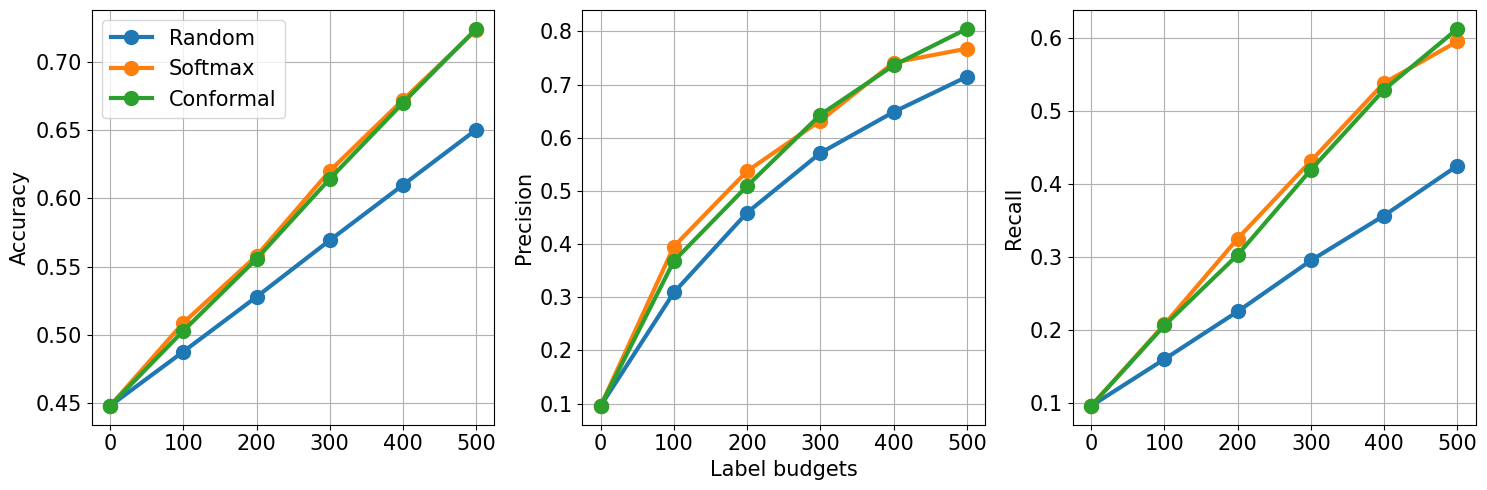

In [58]:
fsize = 15
extended_label_budgets = [0] + label_budgets
plt.figure(figsize=(15, 5))
for i, metric in enumerate(conf_corrected.keys()):
    plt.subplot(1, 3, i+1)
    plt.plot(extended_label_budgets, uncorr_metrics[metric] + rand_corrected[metric], marker='o', linewidth=3, markersize=10)
    plt.plot(extended_label_budgets, uncorr_metrics[metric] + softmax_corrected[metric], marker='o', linewidth=3, markersize=10)
    plt.plot(extended_label_budgets, uncorr_metrics[metric] + conf_corrected[metric], marker='o', linewidth=3, markersize=10)
    plt.xticks(extended_label_budgets, labels=[str(lb) for lb in extended_label_budgets], fontsize=fsize)
    plt.yticks(fontsize=fsize)
    if i == 1: plt.xlabel('Label budgets', fontsize=fsize)
    plt.ylabel(metric, fontsize=fsize)
    if i == 0: plt.legend(['Random', 'Softmax', 'Conformal'], fontsize=fsize)
    plt.grid()
plt.tight_layout()
plt.savefig('./BGR/figures/conformal/task3_lb_resnet.pdf')

How correlated are the softmax entropies and the set sizes?

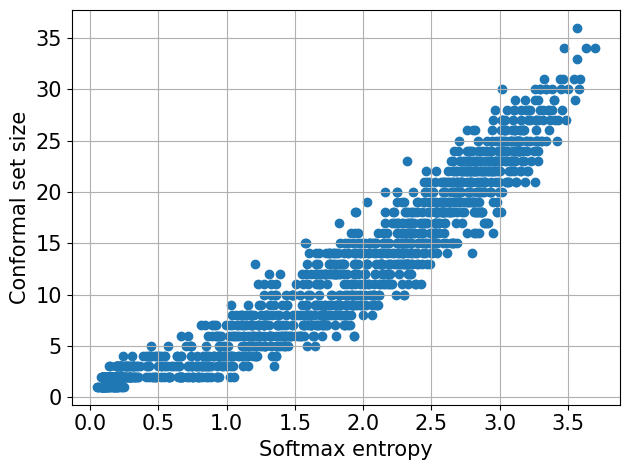

In [33]:
fsize = 15
plt.scatter(entropies, prediction_set_sizes)
plt.xlabel('Softmax entropy', fontsize=fsize); plt.ylabel('Conformal set size', fontsize=fsize)
plt.xticks(fontsize=fsize); plt.yticks(fontsize=fsize)
plt.grid()
plt.tight_layout()
plt.savefig('./BGR/figures/conformal/scatter_entropies_sizes.pdf')

In [ ]:
# Select top_k most uncertain horizon predictions
_, top_ind_soft  = torch.topk(entropies, len(entropies))
top_ind_soft = top_ind_soft.cpu().numpy()
_, top_ind_sizes = torch.topk(torch.tensor(prediction_set_sizes), len(entropies))
top_ind_sizes = top_ind_sizes.cpu().numpy()

# Get rankings of sorted samples
ranks_soft  = np.argsort(top_ind_soft)
ranks_sizes = np.argsort(top_ind_sizes)

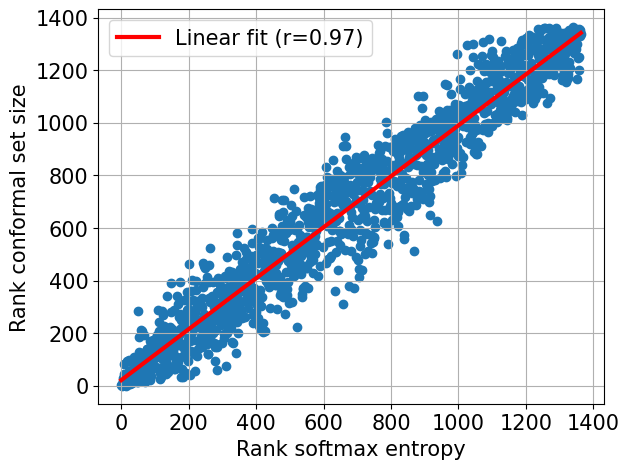

In [50]:
fsize = 15
plt.scatter(ranks_soft, ranks_sizes)
slope, intercept, r_value, _, _ = linregress(ranks_soft, ranks_sizes)
x_vals = np.linspace(min(ranks_soft), max(ranks_soft), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='red', label=f'Linear fit (r={r_value:.2f})', linewidth=3)
plt.xlabel('Rank softmax entropy', fontsize=fsize); plt.ylabel('Rank conformal set size', fontsize=fsize)
plt.xticks(fontsize=fsize); plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize)
plt.grid()
plt.tight_layout()
plt.savefig('./BGR/figures/conformal/scatter_rankings.pdf')

Correct predictions according to entropy in the Softmax (normalized uncertainty thresholds)

In [42]:
# Normalize entropies
norm_entropies = entropies / torch.max(entropies)
norm_entropies

tensor([0.0166, 0.3629, 0.8208,  ..., 0.2665, 0.2764, 0.6764])

In [44]:
softmax_corrected = {}
softmax_corrected['accuracy'] = []; softmax_corrected['precision'] = []; softmax_corrected['recall'] = []
for ut in uncert_thresholds:
    # Select predictions with uncertainty higher than current threshold
    uncert_indices = torch.nonzero(norm_entropies > ut, as_tuple=False).squeeze()
    uncert_indices = uncert_indices.cpu().numpy()

    # Replace these uncertain predictions with the oracle's answers (the ground truth depths)
    pred_indices_test_oracle_soft = pred_indices_test.clone().detach()
    pred_indices_test_oracle_soft[uncert_indices] = all_true_hor_inds_test[uncert_indices]

    # Get accuracy for corrected predictions
    accuracy = (pred_indices_test_oracle_soft == all_true_hor_inds_test).float().mean().item()

    # Get precision and recall after corrections
    precision = precision_score(all_true_hor_inds_test.cpu().numpy(), pred_indices_test_oracle_soft.cpu().numpy(), average='macro', zero_division=0)
    recall = recall_score(all_true_hor_inds_test.cpu().numpy(), pred_indices_test_oracle_soft.cpu().numpy(), average='macro', zero_division=0)

    softmax_corrected['accuracy'].append(accuracy); softmax_corrected['precision'].append(precision); softmax_corrected['recall'].append(recall)
    print(f"For lb = {ut}: accuracy = {accuracy:.4f}, precision = {precision:.4f}, recall = {recall:.4f}")

For lb = 0.9: accuracy = 0.4655, precision = 0.1851, recall = 0.1272
For lb = 0.8: accuracy = 0.5513, precision = 0.5210, recall = 0.3032
For lb = 0.7: accuracy = 0.6518, precision = 0.6801, recall = 0.4838
For lb = 0.6: accuracy = 0.7493, precision = 0.7818, recall = 0.6208
For lb = 0.5: accuracy = 0.8211, precision = 0.8738, recall = 0.7374


Correct predictions according to sizes of prediction sets (normalized uncertainty thresholds)

In [53]:
# Normalize prediction set sizes
norm_prediction_set_sizes = torch.tensor(prediction_set_sizes, dtype = torch.float) 
norm_prediction_set_sizes /= torch.max(norm_prediction_set_sizes)
norm_prediction_set_sizes

tensor([0.0278, 0.1667, 0.6667,  ..., 0.0833, 0.1389, 0.5556])

In [54]:
conf_corrected = {}
conf_corrected['accuracy'] = []; conf_corrected['precision'] = []; conf_corrected['recall'] = []
for ut in uncert_thresholds:
    # Select predictions with uncertainty higher than current threshold
    uncert_indices = torch.nonzero(norm_prediction_set_sizes > ut, as_tuple=False).squeeze()
    uncert_indices = uncert_indices.cpu().numpy()

    # Replace these uncertain predictions with the oracle's answers (the ground truth depths)
    pred_indices_test_oracle_conform = pred_indices_test.clone().detach()
    pred_indices_test_oracle_conform[uncert_indices] = all_true_hor_inds_test[uncert_indices]

    # Get accuracy for corrected predictions
    accuracy = (pred_indices_test_oracle_conform == all_true_hor_inds_test).float().mean().item()

    # Get precision and recall after corrections
    precision = precision_score(all_true_hor_inds_test.cpu().numpy(), pred_indices_test_oracle_conform.cpu().numpy(), average='macro', zero_division=0)
    recall = recall_score(all_true_hor_inds_test.cpu().numpy(), pred_indices_test_oracle_conform.cpu().numpy(), average='macro', zero_division=0)
    
    conf_corrected['accuracy'].append(accuracy); conf_corrected['precision'].append(precision); conf_corrected['recall'].append(recall)
    print(f"For lb = {ut}: accuracy = {accuracy:.4f}, precision = {precision:.4f}, recall = {recall:.4f}")

For lb = 0.9: accuracy = 0.4516, precision = 0.1061, recall = 0.0978
For lb = 0.8: accuracy = 0.4670, precision = 0.1964, recall = 0.1276
For lb = 0.7: accuracy = 0.5015, precision = 0.3602, recall = 0.1962
For lb = 0.6: accuracy = 0.5887, precision = 0.5437, recall = 0.3490
For lb = 0.5: accuracy = 0.6525, precision = 0.6766, recall = 0.4766


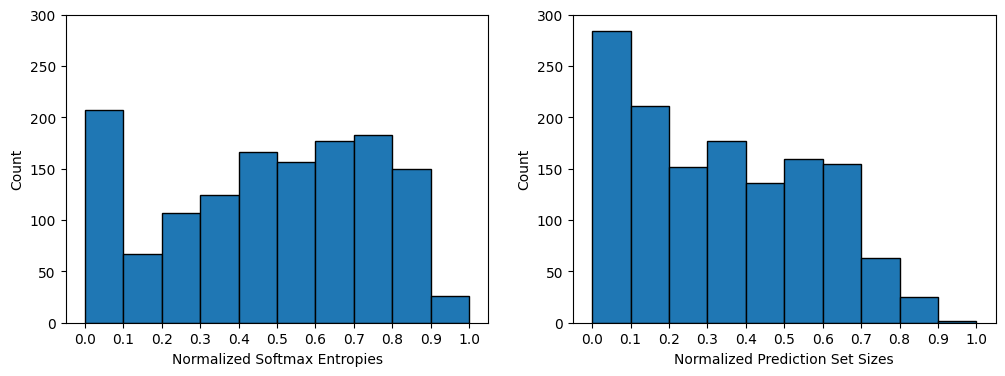

In [73]:
bin_edges = np.arange(0.0, 1.1, 0.1)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(norm_entropies.cpu().numpy(), bins=bin_edges, edgecolor='black')
plt.xlabel('Normalized Softmax Entropies'); plt.ylabel('Count')
plt.ylim([0, 300])
plt.xticks(bin_edges)

plt.subplot(122)
plt.hist(norm_prediction_set_sizes.cpu().numpy(), bins=bin_edges, edgecolor='black')
plt.xlabel('Normalized Prediction Set Sizes'); plt.ylabel('Count')
plt.ylim([0, 300])
plt.xticks(bin_edges)
plt.show()

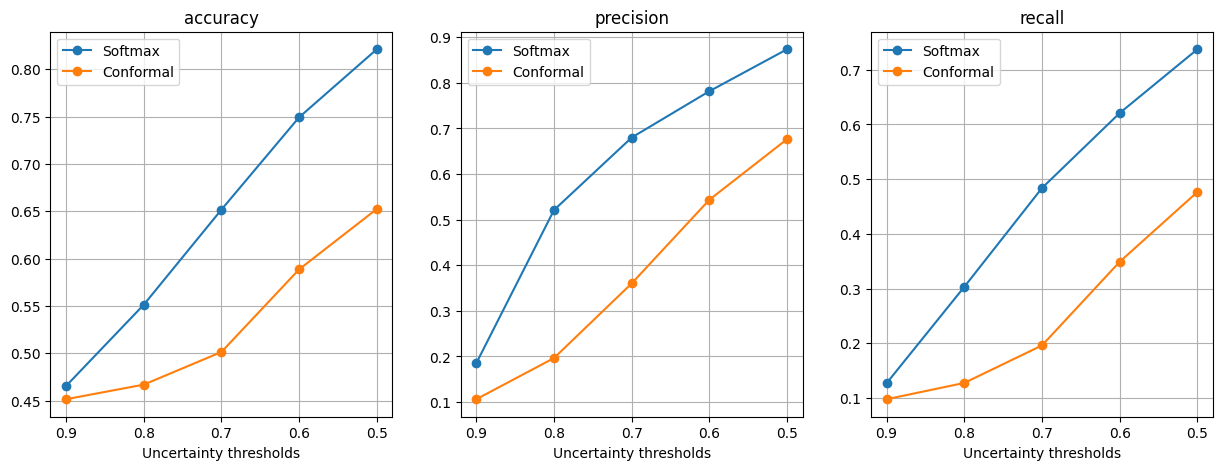

In [64]:
plt.figure(figsize=(15, 5))
for i, metric in enumerate(conf_corrected.keys()):
    plt.subplot(1, 3, i+1)
    #plt.plot(label_budgets, rand_corrected[metric])
    plt.plot(uncert_thresholds, softmax_corrected[metric], '-o')
    plt.plot(uncert_thresholds, conf_corrected[metric], '-o')
    plt.xticks(uncert_thresholds, labels=[str(ut) for ut in uncert_thresholds])
    plt.xlabel('Uncertainty thresholds'); plt.title(metric)
    plt.legend(['Softmax', 'Conformal'])
    plt.grid()
    plt.gca().invert_xaxis()